In [5]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

c:\program files\python35\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\program files\python35\lib\site-packages\scipy\sparse\sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [6]:
import warnings
warnings.filterwarnings('ignore')

## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейки нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

In [12]:
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def clean(words):
    clean = [morph.parse(word)[0].normal_form for word in words if word.isalnum()]
    return clean

### 1) Возьмем те же данные и нормализуем (дополнительно убрав стоп-слова и оставив только isalnum()

In [13]:
habr_texts = [clean(word_tokenize(remove_tags(text.lower()))) for text in open('habr_texts.txt', "r", encoding="utf-8")]

In [14]:
def preprocess(text_words):
    return [i for i in text_words if i!="lt" and i!="gt" and i not in stopwords.words('english') and i not in stopwords.words('russian')]

In [15]:
habr_texts = [preprocess(text) for text in habr_texts]

### 2) Добавим n-grams

In [16]:
# вернемся сюда через какое-то время
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.5, 
                           common_terms=set(stopwords.words('russian'))) # можно указать слова, которые не будут учитываться
p = gensim.models.phrases.Phraser(ph)
ngrammed_habr_texts = p[habr_texts]

In [14]:
p[habr_texts[1]]

['введение',
 'и',
 'выбор',
 'решение',
 'рано_или_поздно',
 'наступать',
 'такой',
 'момент',
 'в',
 'жизнь',
 'любой',
 'сообщество',
 'форум',
 'когда',
 'для',
 'привлечение_и_удержание',
 'человек',
 'возникать',
 'острый_необходимость',
 'использование',
 'новое',
 'инструментарий',
 'и',
 'такой',
 'весьма',
 'эффективный',
 'инструмент',
 'являться',
 'то',
 'что',
 'крыться_за_модный',
 'ныне',
 'слово_геймификация',
 'то',
 'есть',
 'использование',
 'характерный',
 'для',
 'игра',
 'приём',
 'и',
 'подход_в_неигровой',
 'процесс',
 'по',
 'привлечение_и_вовлечение',
 'участник_сообщество',
 'на',
 'форум',
 'в',
 'создание',
 'активный',
 'и',
 'мощный',
 'информационный',
 'поль',
 'вокруг',
 'наш',
 'продукт',
 'использовать',
 'в',
 'наш',
 'компания_форумный',
 'движок_xenforo',
 'в',
 'настоящее_время',
 'являться',
 'наиболее_популярный',
 'и',
 'быстро_развивающийся',
 'этот',
 'движок',
 'иметь',
 'встроить',
 'система',
 'трофей_основать',
 'на',
 'собственный',
 '

Для BigARTM требуется специальный формат данных. Их несколько, но мы возьмем vowpal wabbit.  
На каждой строчке файла находится одельный текст, записывается такст вот таким образом:  
```doc_name |@class_id word_1:1 word_2:3```  

|@class_id - задает модальность, но когда она одна её можно не указывать.

word_2:3 - слово и его частота (обратите внимание, что : - специальный символ и в словах его быть не может

### 3) Сохраним файл

In [17]:
f = open('habr_texts_2.vw', 'w', encoding="utf-8")

for i, text in enumerate(ngrammed_habr_texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()



Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [18]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [19]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [20]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [21]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [22]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=30, max_df=200)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [23]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

## Эта тетрадка использовалась для генерирования словаря. Остальное в BigARTM_continue_Nikishina

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [39]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(30)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.15, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 30)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.25, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 30)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [40]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [41]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

### Тренируем модель

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

In [42]:
model_artm.num_document_passes = 50
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.433 (ARTM)
Kernel contrast: 0.232 (ARTM)
Kernel purity: 0.570 (ARTM)
Perplexity: 471.417 (ARTM)


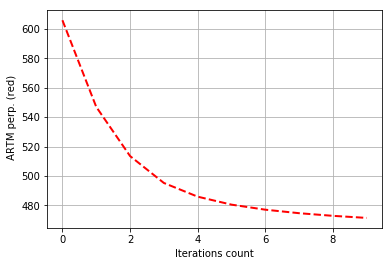

In [43]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [44]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 20)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 20)]))

In [45]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [46]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.690 (ARTM)
Kernel contrast: 0.244 (ARTM)
Kernel purity: 0.633 (ARTM)
Perplexity: 462.989 (ARTM)


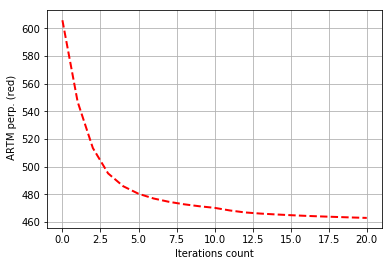

In [47]:
# посмотрим на качество
print_measures(model_artm)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась. Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.

In [48]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ' + ", ".join(model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]))

topic_0: робот, скидка, накопитель, гаджет, аккумулятор, подарок, iphone, девайс, xiaomi, акция
topic_1: amazon, лекция, выступление, go, кандидат, форум, рекламный, спикер, александр, андрей
topic_2: дисплей, ноутбук, напряжение, чип, ток, гб, видеокарта, клавиатура, usb, аккумулятор
topic_3: vr, персонаж, сцена, враг, движок, герой, жанр, спрайт, комната, game
topic_4: пациент, клетка, болезнь, врач, организм, заболевание, ген, лечение, животное, бактерия
topic_5: ibm, звонок, хостинг, резервный, заявка, цод, предприятие, 1с, oracle, crm
topic_6: метка, маршрутизатор, шлюз, кабель, коммутатор, маршрут, маска, приёмник, битый, tcp
topic_7: маркетинг, планирование, образование, школа, инвестор, студент, scrum, зарплата, профессия, инвестиция
topic_8: print, char, байт, include, define, unsigned, file, input, f, output
topic_9: div, swift, let, research, props, react, international, science, width, const
topic_10: p, вакансия, параллельный, математика, указатель, математический, блокиро